<a href="https://colab.research.google.com/github/guillemsmk/AB---Applied-Machine-Learning/blob/main/training/FaceMask_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Mask Classification – Applied Machine Learning

## Objetivo del proyecto
El objetivo de este proyecto es entrenar un modelo de Machine Learning capaz de clasificar imágenes de personas en función de si llevan mascarilla o no (`with_mask` / `without_mask`).

Este notebook cubre las fases de:
- Carga y exploración del dataset
- Preprocesamiento de los datos
- Entrenamiento de un modelo de Deep Learning
- Evaluación del rendimiento del modelo

El modelo entrenado se integrará posteriormente en una aplicación web desplegada en Vercel.


# **Importación de librerías**

In [1]:
# Manejo de archivos y rutas
import os
from pathlib import Path

# Utilidades generales
import json
import random
import numpy as np

# Visualización
import matplotlib.pyplot as plt

# Machine Learning y Deep Learning
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report


# **Configuración del entorno**

In [2]:
# Comprobamos la versión de TensorFlow y si hay GPU disponible.
# En caso de disponer de GPU, el entrenamiento será más rápido.

print("TensorFlow version:", tf.__version__)
print("Available GPUs:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.19.0
Available GPUs: []


# **Carga del dataset**

In [3]:
# El dataset se ha descargado desde Kaggle y se ha subido a Google Colab en formato ZIP.
# A continuación, se descomprime y se almacena en el directorio /content/data.

ZIP_NAME = "archive.zip"  # Nombre del archivo ZIP subido a Colab

DATA_DIR = Path("/content/data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

# Descomprimir el dataset
!unzip -q "/content/{ZIP_NAME}" -d "/content/data"

# Mostrar estructura de carpetas para verificar que el dataset se ha cargado correctamente
print("Estructura del dataset:")
!find /content/data -maxdepth 3 -type d | head -n 40


Estructura del dataset:
/content/data
/content/data/Face Mask Dataset
/content/data/Face Mask Dataset/Test
/content/data/Face Mask Dataset/Test/WithMask
/content/data/Face Mask Dataset/Test/WithoutMask
/content/data/Face Mask Dataset/Train
/content/data/Face Mask Dataset/Train/WithMask
/content/data/Face Mask Dataset/Train/WithoutMask
/content/data/Face Mask Dataset/Validation
/content/data/Face Mask Dataset/Validation/WithMask
/content/data/Face Mask Dataset/Validation/WithoutMask


# **Detección de splits**

In [4]:
# Esta función busca automáticamente las carpetas de train, validation y test
# para hacer el notebook más robusto ante cambios de estructura.

def find_split_dirs(base_path: Path):
    split_dirs = []
    for p in base_path.rglob("*"):
        if p.is_dir() and p.name.lower() in [
            "train", "training", "val", "validation", "test", "testing"
        ]:
            split_dirs.append(p)
    return split_dirs

split_dirs = find_split_dirs(DATA_DIR)

for d in split_dirs:
    print(d)


/content/data/Face Mask Dataset/Test
/content/data/Face Mask Dataset/Train
/content/data/Face Mask Dataset/Validation


# **Definición de rutas**

In [7]:
# Ajustamos estas rutas según la estructura detectada previamente.
# Estas carpetas contienen las imágenes organizadas por clase.

TRAIN_DIR = Path("/content/data/Face Mask Dataset/Train")
VAL_DIR   = Path("/content/data/Face Mask Dataset/Validation")
TEST_DIR  = Path("/content/data/Face Mask Dataset/Test")

print("TRAIN_DIR exists:", TRAIN_DIR.exists(), TRAIN_DIR)
print("VAL_DIR exists:", VAL_DIR.exists(), VAL_DIR)
print("TEST_DIR exists:", TEST_DIR.exists(), TEST_DIR)

# Mostramos las clases disponibles en el conjunto de entrenamiento
print("Clases en train:", [p.name for p in TRAIN_DIR.iterdir() if p.is_dir()])


TRAIN_DIR exists: True /content/data/Face Mask Dataset/Train
VAL_DIR exists: True /content/data/Face Mask Dataset/Validation
TEST_DIR exists: True /content/data/Face Mask Dataset/Test
Clases en train: ['WithMask', 'WithoutMask']


# **Exploración y Análisis de los datos**

In [8]:
# Contamos el número de imágenes por clase en el conjunto de entrenamiento.

def count_images_by_class(dir_path: Path):
    counts = {}
    for class_dir in dir_path.iterdir():
        if class_dir.is_dir():
            counts[class_dir.name] = len(list(class_dir.glob("*")))
    return counts

train_counts = count_images_by_class(TRAIN_DIR)

print("Número de imágenes por clase (train):")
train_counts


Número de imágenes por clase (train):


{'WithMask': 5000, 'WithoutMask': 5000}

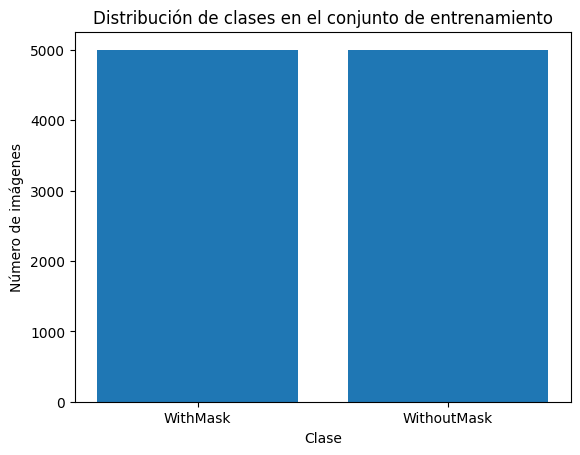

In [9]:
# Visualización de la distribución de clases

plt.figure()
plt.bar(train_counts.keys(), train_counts.values())
plt.title("Distribución de clases en el conjunto de entrenamiento")
plt.xlabel("Clase")
plt.ylabel("Número de imágenes")
plt.show()


# **Visualización de ejemplos**

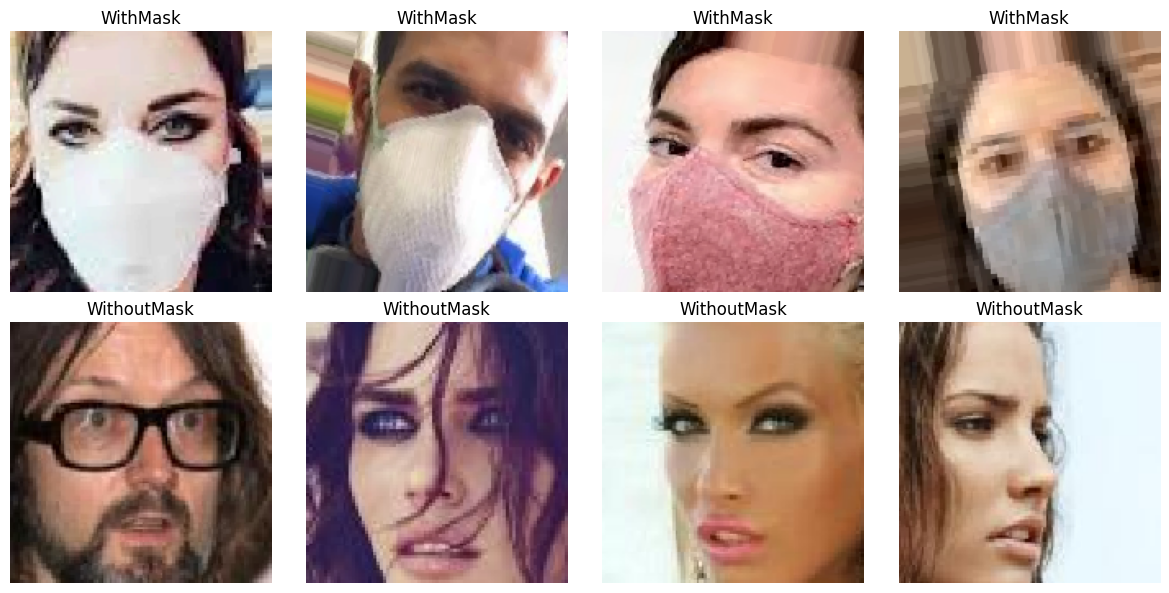

In [10]:
# Mostramos ejemplos de imágenes de cada clase para entender la variabilidad del dataset.

def show_sample_images(dir_path: Path, classes, samples_per_class=4, img_size=(160, 160)):
    plt.figure(figsize=(samples_per_class * 3, len(classes) * 3))
    index = 1

    for cls in classes:
        images = list((dir_path / cls).glob("*"))
        random.shuffle(images)

        for i in range(min(samples_per_class, len(images))):
            img = tf.keras.utils.load_img(images[i], target_size=img_size)
            plt.subplot(len(classes), samples_per_class, index)
            plt.imshow(img)
            plt.axis("off")
            plt.title(cls)
            index += 1

    plt.tight_layout()
    plt.show()

classes = list(train_counts.keys())
show_sample_images(TRAIN_DIR, classes)


# **Parámetros globales de entrenamiento**

In [12]:
# IMG_SIZE: tamaño al que se redimensionan las imágenes.
# BATCH_SIZE: número de imágenes por lote (batch) durante el entrenamiento.
# SEED: semilla para reproducibilidad.

IMG_SIZE = (224, 224)     # estándar para MobileNetV2
BATCH_SIZE = 32
SEED = 42

# **Carga de datasets con image_dataset_from_directory**

In [13]:
# Keras crea automáticamente las etiquetas según el nombre de las subcarpetas
# dentro de TRAIN_DIR / VAL_DIR / TEST_DIR.

train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=False
)

# Guardamos el orden de clases (esto se exporta para usarlo en la app)
class_names = train_ds.class_names
print("Orden de clases:", class_names)

Found 10000 files belonging to 2 classes.
Found 800 files belonging to 2 classes.
Found 992 files belonging to 2 classes.
Orden de clases: ['WithMask', 'WithoutMask']


# **Optimización del pipeline**

In [14]:
# cache(): guarda batches en memoria (acelera si cabe en RAM)
# prefetch(): prepara el siguiente batch mientras el modelo entrena

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds  = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# **Aumento de datos**

In [15]:
# Añadimos variaciones artificiales para mejorar generalización y reducir overfitting.

aumento_datos = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
], name="aumento_datos")

# **Aprendizaje con MobileNetV2**

In [16]:
# Usamos MobileNetV2 preentrenado en ImageNet como extractor de características.
# En fase 1 congelamos la base y entrenamos solo la cabeza clasificadora.

base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False

inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = aumento_datos(inputs)

# Preprocesado específico de MobileNetV2
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)

x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)

# Binaria: una neurona con sigmoid
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs, outputs)

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ aumento_datos (Sequential)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# **Compilación del modelo**

In [17]:
# loss: binary_crossentropy para clasificación binaria
# optimizer: Adam
# metric: accuracy

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# **Fase 1 del entrenamiento**

In [18]:
# Entrenamos solo la cabeza del modelo (rápido y suele dar buen resultado inicial).

EPOCHS_1 = 5

history_1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_1
)

Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 379s 1s/step - accuracy: 0.9375 - loss: 0.1519 - val_accuracy: 0.9962 - val_loss: 0.0139
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 365s 1s/step - accuracy: 0.9954 - loss: 0.0166 - val_accuracy: 0.9987 - val_loss: 0.0063
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 347s 1s/step - accuracy: 0.9962 - loss: 0.0119 - val_accuracy: 0.9987 - val_loss: 0.0050
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 375s 1s/step - accuracy: 0.9975 - loss: 0.0094 - val_accuracy: 0.9987 - val_loss: 0.0043
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 344s 1s/step - accuracy: 0.9974 - loss: 0.0073 - val_accuracy: 0.9987 - val_loss: 0.0048


# **Fase 2 - Fine-tuning**

In [20]:
# Descongelamos parte final de MobileNetV2 para especializarlo al dominio de mascarillas.
# Usamos un LR más bajo para evitar "romper" el preentrenamiento.
# En esta fase, hemos bajado los epochs a 2, ya que en la primera fase podemos observar que encontramos una muy buena precisión en los primeros epochs y el resto subían un mínimo.

base_model.trainable = True

fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

EPOCHS_2 = 2

history_2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_2
)

Epoch 1/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 562s 2s/step - accuracy: 0.9838 - loss: 0.0435 - val_accuracy: 0.9987 - val_loss: 0.0028
Epoch 2/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 546s 2s/step - accuracy: 0.9946 - loss: 0.0178 - val_accuracy: 1.0000 - val_loss: 0.0011


# **Curvas de entrenamiento**

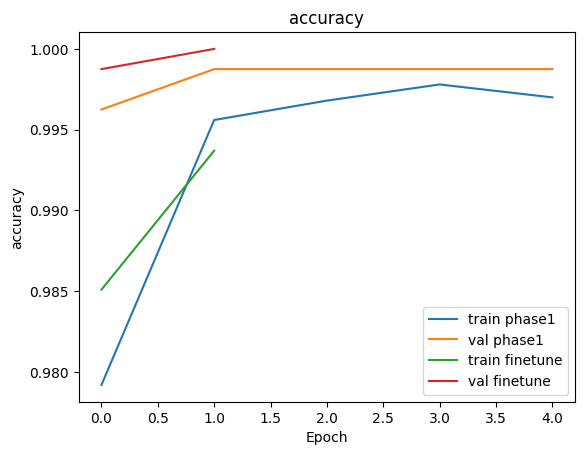

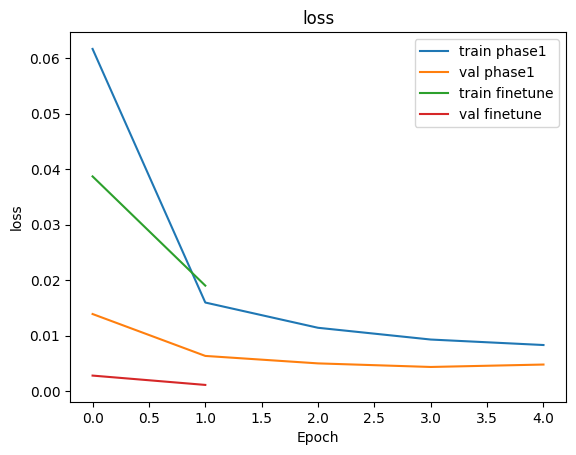

In [21]:
# Nos ayudan a detectar overfitting: si train sube pero val baja/estanca, hay sobreajuste.

def plot_metric(histories, metric="accuracy"):
    plt.figure()
    for h, label in histories:
        plt.plot(h.history[metric], label=f"train {label}")
        plt.plot(h.history[f"val_{metric}"], label=f"val {label}")
    plt.title(metric)
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.legend()
    plt.show()

def plot_loss(histories):
    plt.figure()
    for h, label in histories:
        plt.plot(h.history["loss"], label=f"train {label}")
        plt.plot(h.history["val_loss"], label=f"val {label}")
    plt.title("loss")
    plt.xlabel("Epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

histories = [(history_1, "phase1"), (history_2, "finetune")]

plot_metric(histories, "accuracy")
plot_loss(histories)

# **Evaluación final**

In [22]:
# Medimos rendimiento final sobre datos no vistos (generalización).

test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f} | Test loss: {test_loss:.4f}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 28s 907ms/step - accuracy: 1.0000 - loss: 0.0048
Test accuracy: 1.0000 | Test loss: 0.0026


# **Matriz de confusión y reporte**

In [23]:
# Análisis más detallado: errores por clase, precisión, recall, F1-score.

y_true = []
y_pred = []

for images, labels in test_ds:
    probs = model.predict(images).flatten()
    preds = (probs > 0.5).astype(int)
    y_true.extend(labels.numpy().astype(int))
    y_pred.extend(preds)

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 907ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 888ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 860ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 793ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 841ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 888ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 809ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 984ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 924ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 804ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 882ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 927ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 906ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 831ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 926ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 909ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 935ms/ste

# **Visualización de errores**

In [24]:
# Mostramos ejemplos donde el modelo se equivoca para entender causas (ángulo, iluminación, blur, etc.)

def show_misclassifications(dataset, n=12):
    wrong = []
    for images, labels in dataset:
        probs = model.predict(images).flatten()
        preds = (probs > 0.5).astype(int)
        for i in range(len(labels)):
            if preds[i] != int(labels[i].numpy()):
                wrong.append((images[i].numpy().astype("uint8"),
                              int(labels[i].numpy()),
                              int(preds[i]),
                              float(probs[i])))
            if len(wrong) >= n:
                break
        if len(wrong) >= n:
            break

    if len(wrong) == 0:
        print("No se encontraron errores en las primeras batches (¡genial!).")
        return

    plt.figure(figsize=(12, 8))
    for idx, (img, t, p, prob) in enumerate(wrong):
        plt.subplot(3, 4, idx + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"T:{class_names[t]} | P:{class_names[p]}\nProb:{prob:.2f}")
    plt.tight_layout()
    plt.show()

show_misclassifications(test_ds, n=12)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 828ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 790ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 922ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 932ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 861ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 790ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 942ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 816ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 883ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 938ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 884ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 928ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 838ms/

# **Exportación del modelo**

In [ ]:
# Guardamos el modelo en formato Keras y un JSON con el orden de las clases.
# Esto es clave para que la app interprete correctamente la salida del modelo.

EXPORT_DIR = Path("/content/exports")
EXPORT_DIR.mkdir(parents=True, exist_ok=True)

MODEL_PATH = EXPORT_DIR / "model.keras"
LABELS_PATH = EXPORT_DIR / "labels.json"

model.save(MODEL_PATH)

with open(LABELS_PATH, "w") as f:
    json.dump({"class_names": class_names}, f)

print("Modelo guardado en:", MODEL_PATH)
print("Labels guardadas en:", LABELS_PATH)

!ls -lah /content/exports